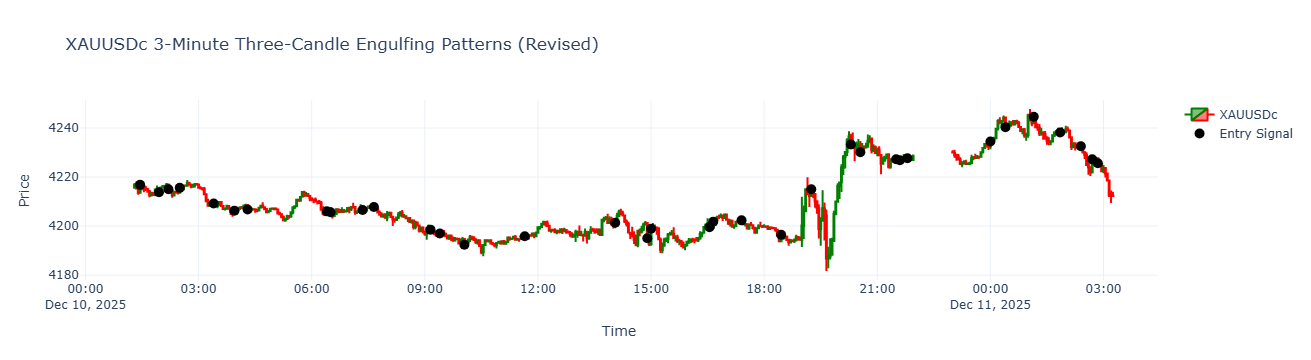

True

In [14]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()

# -------------------------
# 2. Fetch XAUUSDc 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3  # 3-minute candles
num_bars = 500

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
if rates is None:
    print("Failed to fetch data")
    mt5.shutdown()
    exit()

# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------
# 3. Identify bullish and bearish patterns
# -------------------------
signals = []

for i in range(2, len(df)):
    pos0 = df.iloc[i]     # Current candle
    pos1 = df.iloc[i-1]   # Previous candle
    pos2 = df.iloc[i-2]   # Candle before previous

    # ---------- Bearish Pattern ----------
    # Position 0 bearish, pos1 bullish, pos2 bullish
    # Close of pos0 < open of pos1
    # High of pos1 > highs of pos0 and pos2
    if (pos0['close'] < pos0['open']) and (pos1['close'] > pos1['open']) and (pos2['close'] > pos2['open']):
        if (pos0['close'] < pos1['open']) and (pos1['high'] > pos0['high']) and (pos1['high'] > pos2['high']):
            signals.append({
                'time': pos0['time'],
                'price': pos0['close'],
                'type': 'bearish'
            })

    # ---------- Bullish Pattern ----------
    # Position 0 bullish, pos1 bearish, pos2 bearish
    # Close of pos0 > open of pos1
    # Low of pos1 < lows of pos0 and pos2
    if (pos0['close'] > pos0['open']) and (pos1['close'] < pos1['open']) and (pos2['close'] < pos2['open']):
        if (pos0['close'] > pos1['open']) and (pos1['low'] < pos0['low']) and (pos1['low'] < pos2['low']):
            signals.append({
                'time': pos0['time'],
                'price': pos0['close'],
                'type': 'bullish'
            })

# -------------------------
# 4. Plot candlestick chart
# -------------------------
fig = go.Figure(data=[go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name='XAUUSDc'
)])

# Add entry signals as black circles
if signals:
    signals_df = pd.DataFrame(signals)
    fig.add_trace(go.Scatter(
        x=signals_df['time'],
        y=signals_df['price'],
        mode='markers',
        marker=dict(symbol='circle', color='black', size=10),
        name='Entry Signal'
    ))

# White theme layout
fig.update_layout(
    title='XAUUSDc 3-Minute Three-Candle Engulfing Patterns (Revised)',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    template='plotly_white'
)

fig.show()

# -------------------------
# 5. Shutdown MT5
# -------------------------
mt5.shutdown()


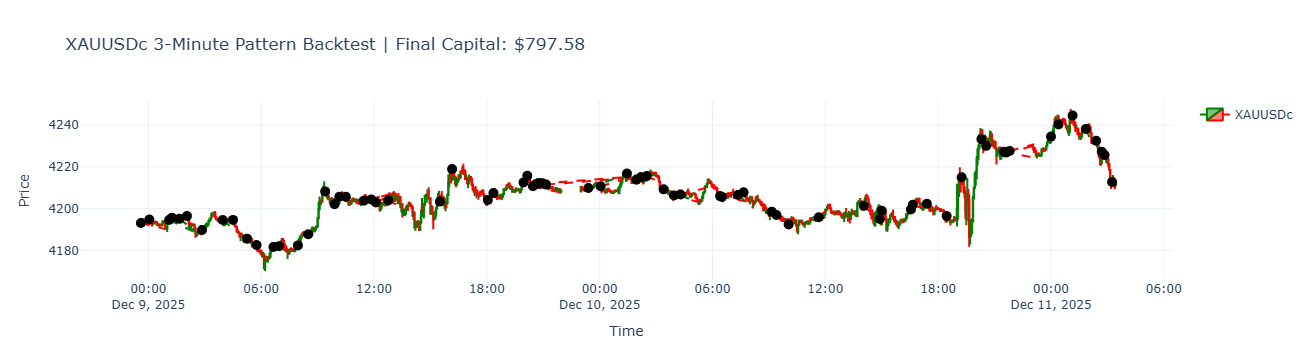

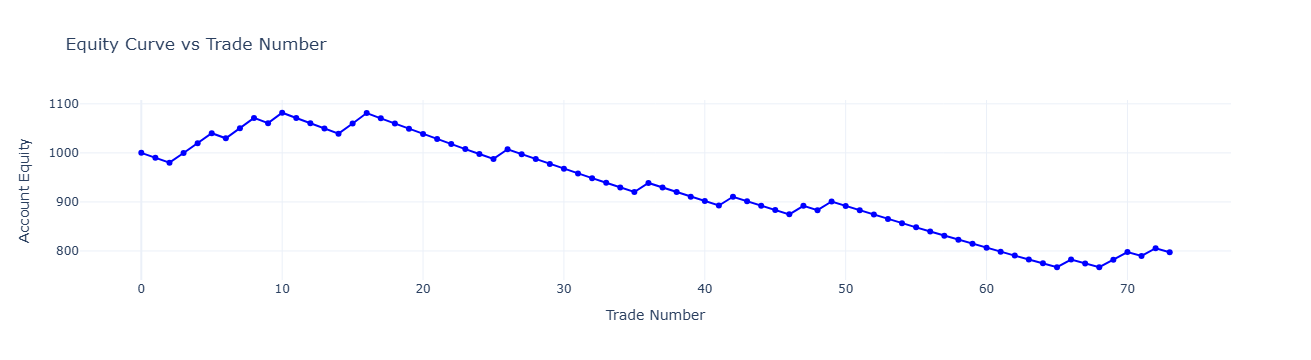

True

In [22]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()

# -------------------------
# 2. Fetch XAUUSDc 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 1000

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
if rates is None:
    print("Failed to fetch data")
    mt5.shutdown()
    exit()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------
# 3. Pattern detection and trade simulation
# -------------------------
initial_capital = 1000
account = initial_capital
risk_per_trade = 0.01
stoploss_units = 3
takeprofit_units = stoploss_units * 2  # 2R

trades = []
equity_list = [account]  # start with initial capital

for i in range(2, len(df)):
    pos0 = df.iloc[i]
    pos1 = df.iloc[i-1]
    pos2 = df.iloc[i-2]

    # ---------- Bearish Pattern ----------
    if (pos0['close'] < pos0['open']) and (pos1['close'] > pos1['open']) and (pos2['close'] > pos2['open']):
        if (pos0['close'] < pos1['open']) and (pos1['high'] > pos0['high']) and (pos1['high'] > pos2['high']):
            entry = pos0['close']
            stoploss = entry + stoploss_units
            takeprofit = entry - takeprofit_units
            trade_risk = risk_per_trade * account
            position_size = trade_risk / stoploss_units
            hit_tp = False
            hit_sl = False
            for j in range(i+1, len(df)):
                low = df.iloc[j]['low']
                high = df.iloc[j]['high']
                if low <= takeprofit:
                    hit_tp = True
                    exit_price = takeprofit
                    break
                elif high >= stoploss:
                    hit_sl = True
                    exit_price = stoploss
                    break
            color = 'gray'
            pnl = 0
            if hit_tp:
                pnl = position_size * (entry - takeprofit)
                account += pnl
                color = 'green'
            elif hit_sl:
                pnl = position_size * (entry - stoploss)
                account += pnl
                color = 'red'
            trades.append({
                'entry_time': pos0['time'],
                'exit_time': df.iloc[j]['time'] if (hit_tp or hit_sl) else df.iloc[-1]['time'],
                'entry': entry,
                'exit': exit_price,
                'type': 'sell',
                'color': color
            })
            equity_list.append(account)

    # ---------- Bullish Pattern ----------
    if (pos0['close'] > pos0['open']) and (pos1['close'] < pos1['open']) and (pos2['close'] < pos2['open']):
        if (pos0['close'] > pos1['open']) and (pos1['low'] < pos0['low']) and (pos1['low'] < pos2['low']):
            entry = pos0['close']
            stoploss = entry - stoploss_units
            takeprofit = entry + takeprofit_units
            trade_risk = risk_per_trade * account
            position_size = trade_risk / stoploss_units
            hit_tp = False
            hit_sl = False
            for j in range(i+1, len(df)):
                low = df.iloc[j]['low']
                high = df.iloc[j]['high']
                if high >= takeprofit:
                    hit_tp = True
                    exit_price = takeprofit
                    break
                elif low <= stoploss:
                    hit_sl = True
                    exit_price = stoploss
                    break
            color = 'gray'
            pnl = 0
            if hit_tp:
                pnl = position_size * (takeprofit - entry)
                account += pnl
                color = 'green'
            elif hit_sl:
                pnl = position_size * (stoploss - entry)
                account += pnl
                color = 'red'
            trades.append({
                'entry_time': pos0['time'],
                'exit_time': df.iloc[j]['time'] if (hit_tp or hit_sl) else df.iloc[-1]['time'],
                'entry': entry,
                'exit': exit_price,
                'type': 'buy',
                'color': color
            })
            equity_list.append(account)

# -------------------------
# 4. Plot candlestick chart with break lines
# -------------------------
fig = go.Figure(data=[go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name='XAUUSDc'
)])

# Plot trades with break lines
for trade in trades:
    fig.add_trace(go.Scatter(
        x=[trade['entry_time'], trade['exit_time']],
        y=[trade['entry'], trade['exit']],
        mode='lines',
        line=dict(color=trade['color'], width=2, dash='dash'),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[trade['entry_time']],
        y=[trade['entry']],
        mode='markers',
        marker=dict(symbol='circle', color='black', size=10),
        showlegend=False
    ))

fig.update_layout(
    title=f'XAUUSDc 3-Minute Pattern Backtest | Final Capital: ${account:.2f}',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    template='plotly_white'
)
fig.show()

# -------------------------
# 5. Plot equity curve (x-axis = trade number)
# -------------------------
equity_fig = go.Figure()
equity_fig.add_trace(go.Scatter(
    x=list(range(len(equity_list))),
    y=equity_list,
    mode='lines+markers',
    line=dict(color='blue', width=2),
    name='Equity Curve'
))
equity_fig.update_layout(
    title='Equity Curve vs Trade Number',
    xaxis_title='Trade Number',
    yaxis_title='Account Equity',
    template='plotly_white'
)
equity_fig.show()

# -------------------------
# 6. Shutdown MT5
# -------------------------
mt5.shutdown()


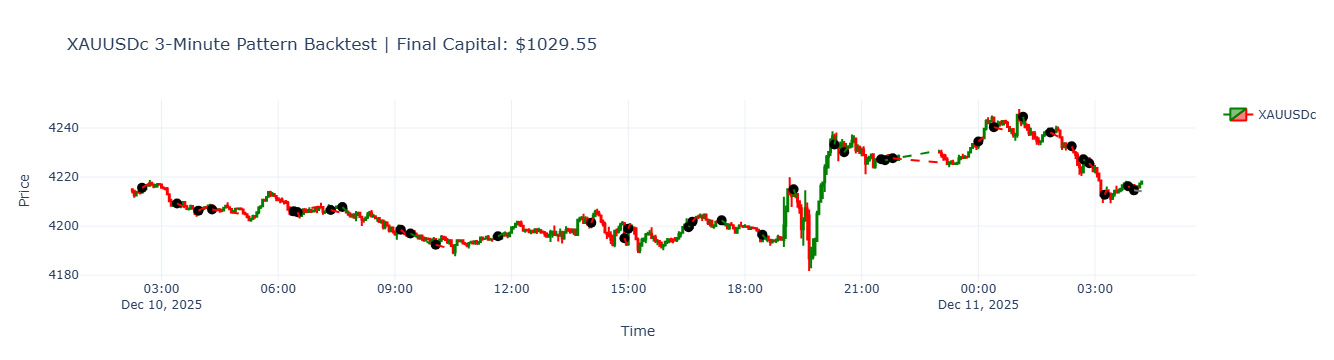

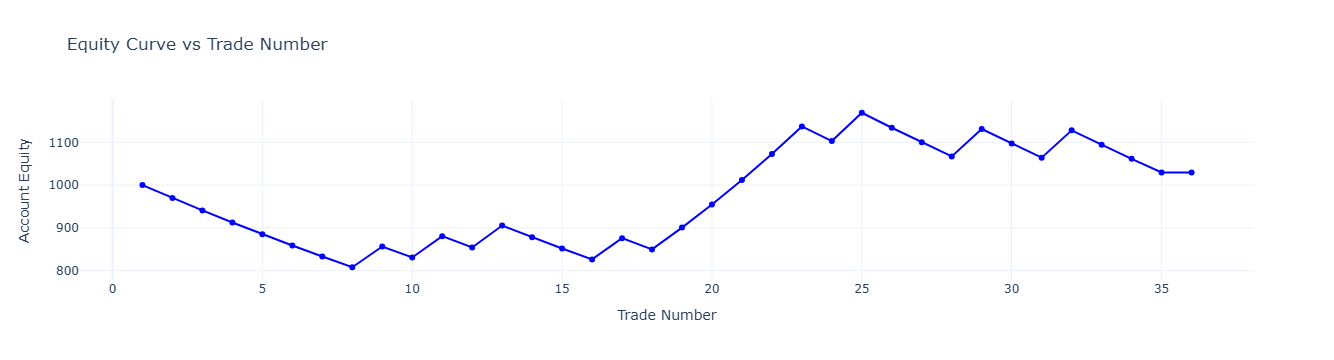

True

In [39]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()

# -------------------------
# 2. Fetch XAUUSDc 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 5000

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
if rates is None:
    print("Failed to fetch data")
    mt5.shutdown()
    exit()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------
# 3. Backtest settings
# -------------------------
initial_capital = 1000
account = initial_capital
risk_per_trade = 0.03
stoploss_units = 2
takeprofit_units = stoploss_units * 2  # 2R

trades = []
equity_list = [account]  # start with initial capital

# -------------------------
# 4. Pattern detection and trade simulation
# -------------------------
for i in range(2, len(df)):
    pos0 = df.iloc[i]
    pos1 = df.iloc[i-1]
    pos2 = df.iloc[i-2]

    # ---------- Bearish Pattern ----------
    if (pos0['close'] < pos0['open']) and (pos1['close'] > pos1['open']) and (pos2['close'] > pos2['open']):
        if (pos0['close'] < pos1['open']) and (pos1['high'] > pos0['high']) and (pos1['high'] > pos2['high']):
            # Execute a BUY-market trade
            entry = pos0['close']
            stoploss = entry - stoploss_units
            takeprofit = entry + takeprofit_units
            trade_risk = risk_per_trade * account
            position_size = trade_risk / stoploss_units
            hit_tp = hit_sl = False
            for j in range(i+1, len(df)):
                low = df.iloc[j]['low']
                high = df.iloc[j]['high']
                if high >= takeprofit:
                    hit_tp = True
                    exit_price = takeprofit
                    break
                elif low <= stoploss:
                    hit_sl = True
                    exit_price = stoploss
                    break
            pnl = 0
            color = 'gray'
            if hit_tp:
                pnl = position_size * (takeprofit - entry)
                account += pnl
                color = 'green'
            elif hit_sl:
                pnl = position_size * (stoploss - entry)
                account += pnl
                color = 'red'
            trades.append({
                'entry_time': pos0['time'],
                'exit_time': df.iloc[j]['time'] if (hit_tp or hit_sl) else df.iloc[-1]['time'],
                'entry': entry,
                'exit': exit_price,
                'type': 'buy',
                'color': color
            })
            equity_list.append(account)

    # ---------- Bullish Pattern ----------
    if (pos0['close'] > pos0['open']) and (pos1['close'] < pos1['open']) and (pos2['close'] < pos2['open']):
        if (pos0['close'] > pos1['open']) and (pos1['low'] < pos0['low']) and (pos1['low'] < pos2['low']):
            # Execute a SELL-market trade
            entry = pos0['close']
            stoploss = entry + stoploss_units
            takeprofit = entry - takeprofit_units
            trade_risk = risk_per_trade * account
            position_size = trade_risk / stoploss_units
            hit_tp = hit_sl = False
            for j in range(i+1, len(df)):
                low = df.iloc[j]['low']
                high = df.iloc[j]['high']
                if low <= takeprofit:
                    hit_tp = True
                    exit_price = takeprofit
                    break
                elif high >= stoploss:
                    hit_sl = True
                    exit_price = stoploss
                    break
            pnl = 0
            color = 'gray'
            if hit_tp:
                pnl = position_size * (entry - takeprofit)
                account += pnl
                color = 'green'
            elif hit_sl:
                pnl = position_size * (entry - stoploss)
                account += pnl
                color = 'red'
            trades.append({
                'entry_time': pos0['time'],
                'exit_time': df.iloc[j]['time'] if (hit_tp or hit_sl) else df.iloc[-1]['time'],
                'entry': entry,
                'exit': exit_price,
                'type': 'sell',
                'color': color
            })
            equity_list.append(account)

# -------------------------
# 5. Plot candlestick chart with breaklines
# -------------------------
fig = go.Figure(data=[go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name='XAUUSDc'
)])

for trade in trades:
    # Entry marker
    fig.add_trace(go.Scatter(
        x=[trade['entry_time']],
        y=[trade['entry']],
        mode='markers',
        marker=dict(symbol='circle', color='black', size=10),
        showlegend=False
    ))
    # Break line entry → exit
    fig.add_trace(go.Scatter(
        x=[trade['entry_time'], trade['exit_time']],
        y=[trade['entry'], trade['exit']],
        mode='lines',
        line=dict(color=trade['color'], width=2, dash='dash'),
        showlegend=False
    ))

fig.update_layout(
    title=f'XAUUSDc 3-Minute Pattern Backtest | Final Capital: ${account:.2f}',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    template='plotly_white'
)
fig.show()

# -------------------------
# 6. Plot equity curve (x-axis = trade number)
# -------------------------
equity_fig = go.Figure()
equity_fig.add_trace(go.Scatter(
    x=list(range(1, len(equity_list)+1)),
    y=equity_list,
    mode='lines+markers',
    line=dict(color='blue', width=2),
    name='Equity Curve'
))
equity_fig.update_layout(
    title='Equity Curve vs Trade Number',
    xaxis_title='Trade Number',
    yaxis_title='Account Equity',
    template='plotly_white'
)
equity_fig.show()

# -------------------------
# 7. Shutdown MT5
# -------------------------
mt5.shutdown()


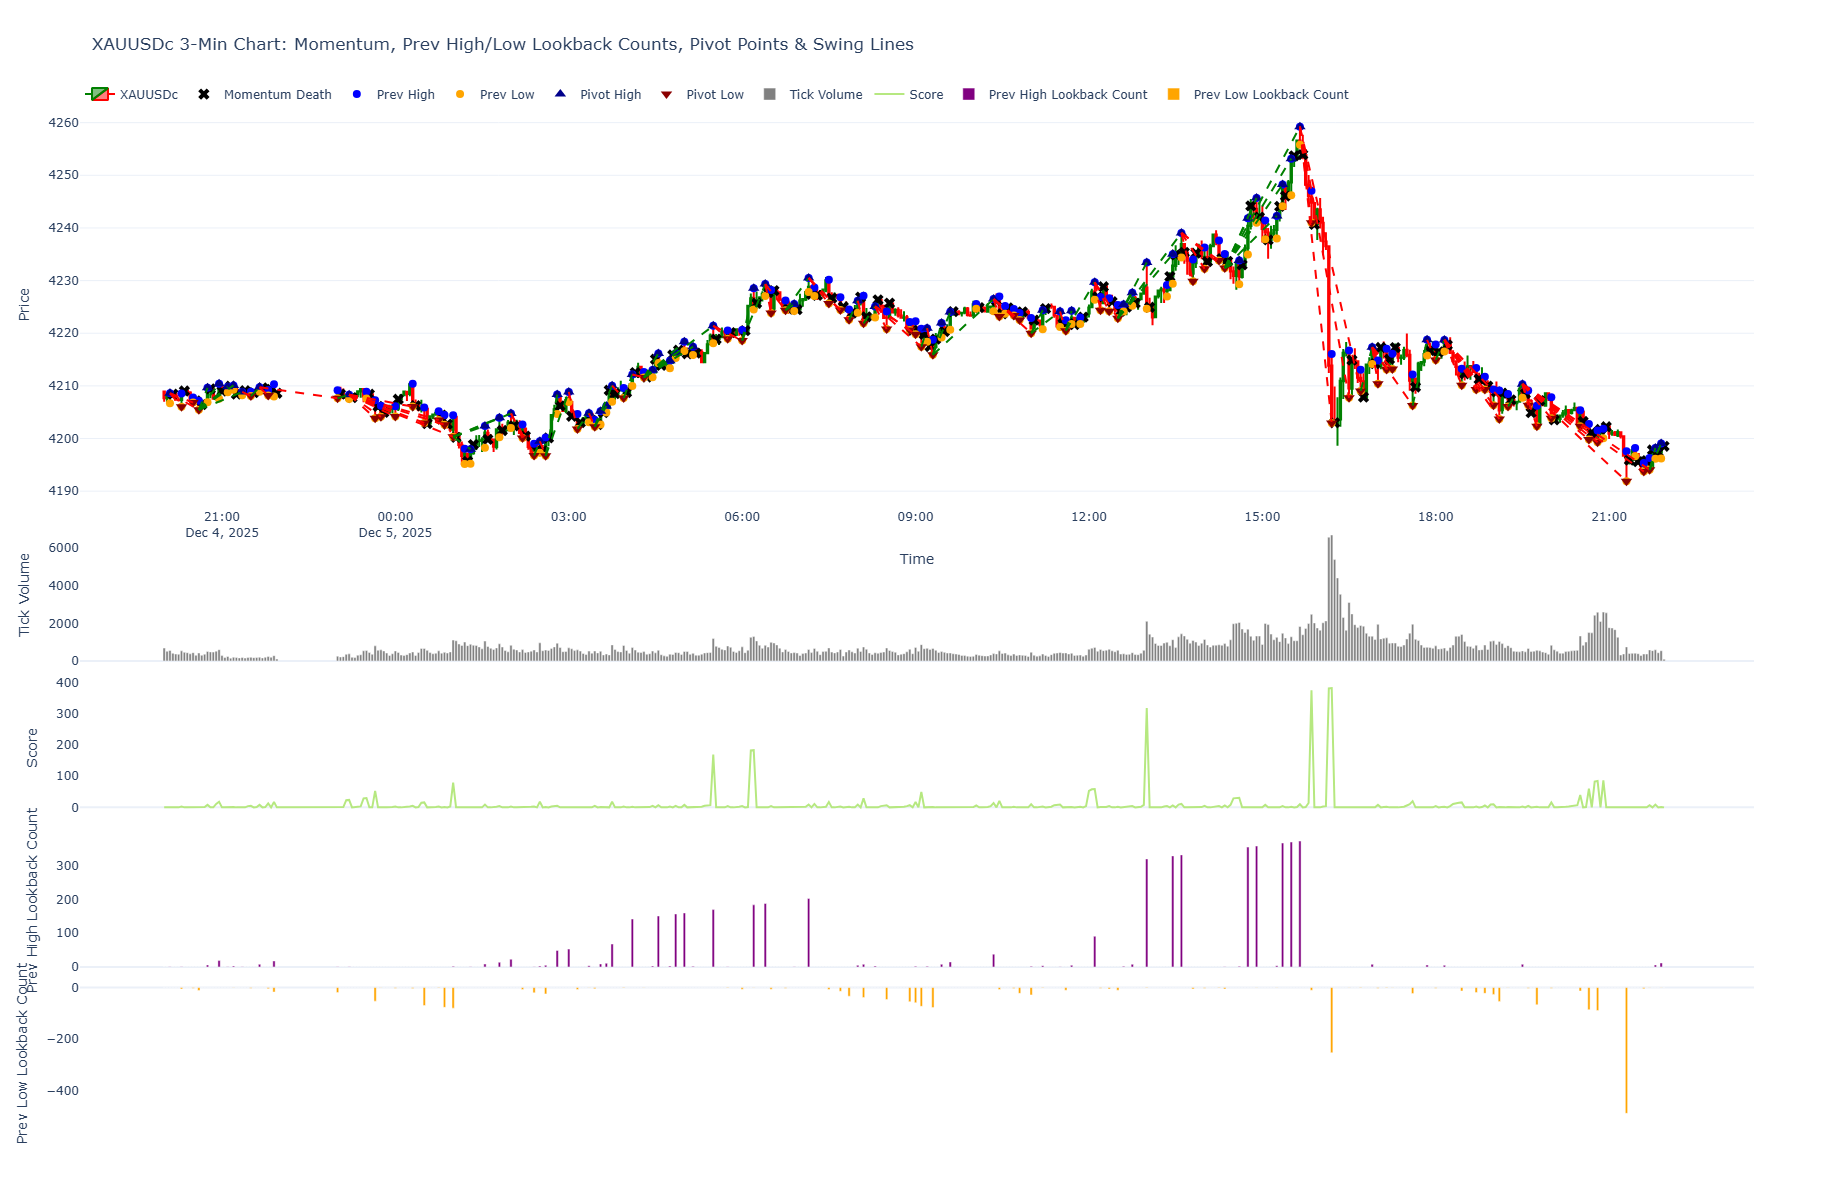

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points and prev high/low marks
# -------------------------
momentum_death_x = []
momentum_death_y = []
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])
        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count

df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 8. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count  # negative

df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 9. Determine Pivot Highs and Lows
# -------------------------
pivot_high_x = []
pivot_high_y = []
pivot_low_x = []
pivot_low_y = []

for i in range(len(df)):
    ph_score = df['prev_high_lookback_score'].iloc[i]
    pl_score = abs(df['prev_low_lookback_score'].iloc[i])

    if ph_score > pl_score and ph_score != 0:
        pivot_high_x.append(df.index[i])
        pivot_high_y.append(df['high'].iloc[i])
    elif pl_score > ph_score and pl_score != 0:
        pivot_low_x.append(df.index[i])
        pivot_low_y.append(df['low'].iloc[i])

# -------------------------
# 10. Connect Pivot Points with Break Lines
# -------------------------
swing_lines = []

# Combine pivot points into sorted list
pivot_points = sorted(
    [(x, y, 'high') for x, y in zip(pivot_high_x, pivot_high_y)] +
    [(x, y, 'low') for x, y in zip(pivot_low_x, pivot_low_y)],
    key=lambda t: t[0]
)

# Map timestamp to index
time_to_idx = {time: idx for idx, time in enumerate(df.index)}

# Iterate through pivot points
for i in range(len(pivot_points)):
    curr_time, curr_price, curr_type = pivot_points[i]

    # Search backward for opposite pivot
    for j in range(i - 1, -1, -1):
        prev_time, prev_price, prev_type = pivot_points[j]
        if prev_type != curr_type:
            line_color = 'green' if curr_type == 'high' else 'red'
            swing_lines.append({
                'x0': prev_time, 'y0': prev_price,
                'x1': curr_time, 'y1': curr_price,
                'color': line_color
            })
            break

# -------------------------
# 11. Plot 5-pane chart
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Pivot markers
fig.add_trace(go.Scatter(
    x=pivot_high_x,
    y=pivot_high_y,
    mode='markers',
    name='Pivot High',
    marker=dict(size=10, color='darkblue', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=pivot_low_x,
    y=pivot_low_y,
    mode='markers',
    name='Pivot Low',
    marker=dict(size=10, color='darkred', symbol='triangle-down'),
    yaxis='y'
))

# Add swing/break lines
for line in swing_lines:
    fig.add_shape(
        type='line',
        x0=line['x0'], y0=line['y0'],
        x1=line['x1'], y1=line['y1'],
        line=dict(color=line['color'], width=2, dash='dash'),
        xref='x', yref='y'
    )

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane (negative)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Layout for 5 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Prev High/Low Lookback Counts, Pivot Points & Swing Lines',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.60, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.45, 0.58], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.30, 0.43], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.15, 0.28], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.00, 0.13], showgrid=False),

    height=1200,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()
